<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 4 of the code drill

The main focus here is to get 99.4% accuracy in less than 8k parameters in less than 15 Epochs

## Importing Libraries



In [1]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(fill=(0,),degrees=(-5,5)), # Randomly rotating 50& of the image in the range -5,5
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [3]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## CONSTANTS

In [4]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
DROPOUT_VALUE = 0.05
EPOCHS = 15

## Data Loading

In [5]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(6),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=6,out_channels=12,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 12,out_channels = 8,kernel_size = (3,3),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             864
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,152
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [-1, 1

In [9]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09882578998804092 Batch_id=468 Accuracy=89.28: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9752/10000 (97.52%)

EPOCH: 1


Loss=0.05692201480269432 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.09679898619651794 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.045112717896699905 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.04086944833397865 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.021233880892395973 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.09468135982751846 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.05672961473464966 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.010386553592979908 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.11233557015657425 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.007162027060985565 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.020916566252708435 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.017439959570765495 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.012405242770910263 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.09229917079210281 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

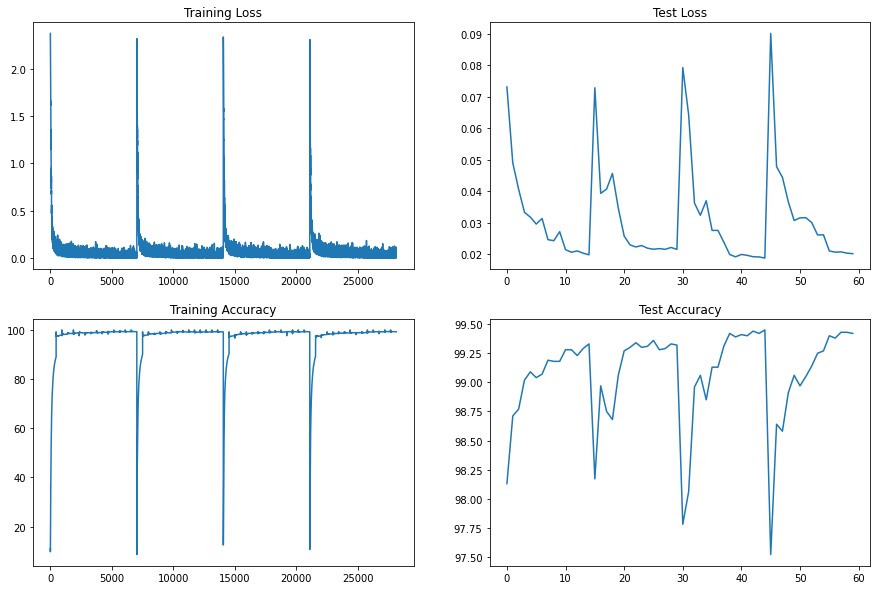

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [18]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08750560134649277 Batch_id=468 Accuracy=89.32: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9770/10000 (97.70%)

EPOCH: 1


Loss=0.1730450838804245 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.12377258390188217 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.0328061543405056 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.06314772367477417 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.03348669782280922 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.04197172820568085 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.01655447855591774 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.016763770952820778 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.023434484377503395 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.03375167399644852 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.016266988590359688 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.013031245209276676 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.010158373974263668 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.04816135764122009 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

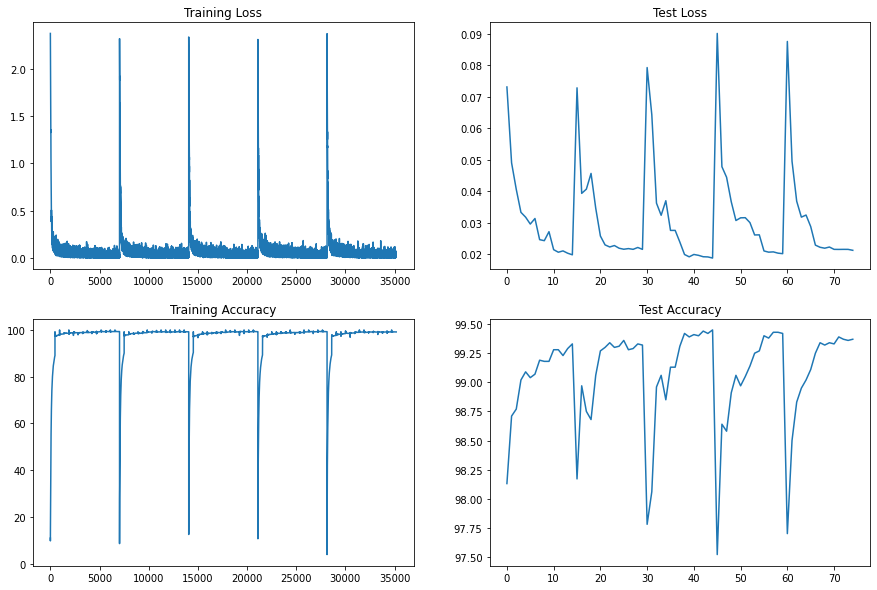

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14324016869068146 Batch_id=468 Accuracy=90.36: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.0673876628279686 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Loss=0.08667515963315964 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.029970817267894745 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.03503379598259926 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.09268102794885635 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.02746777981519699 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.026279164478182793 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.0340152233839035 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.0268640648573637 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.010299795307219028 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.02096753567457199 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.01678568311035633 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.02433016151189804 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.07508450746536255 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:19<00:00, 23.65it/s]



Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)



Text(0.5, 1.0, 'Test Accuracy')

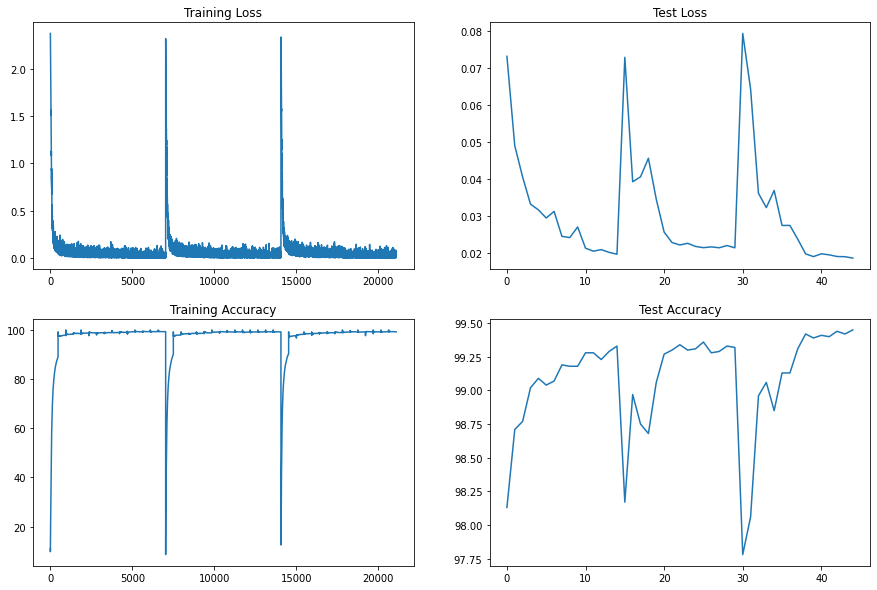

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")